# Segmentation sémantique avec U-Net, Dice Loss et data augmentation
![](https://www.cityscapes-dataset.com/wordpress/wp-content/uploads/2015/07/muenster00.png)

L'objectif de ce projet est de concevoir un modèle de segmentation d’images semantique. La segmentation sémantique est un algorithme de Deep Learning qui associe une catégorie à chaque pixel d'une image. Elle permet de reconnaître un ensemble de pixels qui forment des catégories distinctes.

Les images sont issues du jeux de données de [cityscape](https://www.cityscapes-dataset.com). Le nombre de categorie est réduit de 37 à 8.
  - void
  - flat
  - construction
  - object
  - nature
  - sky
  - human
  - vehicle


Dans ce notebook nous allons explorer un modèle **Unet** qui sera entrainé  avec une perte de type **Catégorical Cross Entropy** et avec une perte de type **Dice**.

## Calcul de la perte

### Dice loss
L’utilisation de l’entropie inter-catégorique comme calcul de perte ne donne pas de bon résultat car elle n’est pas assez précise au niveau de catégorisation des pixels. Le calcul de la perte avec le coefficient de Dice donne de meilleurs résultats avec des classes déséquilibrées.

## Data augmentation
L'augmentation de données permet d’ajouter des images, relativement similaires aux images du jeu 'entrainement. En effet ses images seront modifiées en fonction de certains critères :
•	Retournement horizontal
•	Luminosité et contraste aléatoire
•	Flou
•	Rotation (max 45°)
Nous avons utilisé la bibliothèque ImageDataAugmentor qui permet de réaliser facilement des augmentations d'images. Cette bibliothèque supporte ImageDataGenerator de Keras et albumentations


## Modèle U-Net
Le modèle U-net a été proposé pour la première fois par : Olaf Ronneberger, Philipp Fischer et Thomas Brox dans leur article intitulé "U-Net: Convolutional Networks for Biomedical Image Segmentation". Le modèle U-net est construit sur le modèle FCN-8 pour s'adapter à l'imagerie médicale. 

![](https://miro.medium.com/max/1400/1*f7YOaE4TWubwaFF7Z1fzNw.png)

C'est un modèle symétrique en forme de U séparé par un bottleneck. La première partie appelée contraction ou downsampling effectue l'extraction des caractéristiques contextuelles, la deuxième partie est le bottleneck qui force le modèle à apprendre d'une compression des données d'entrée et la dernière partie (qui est l'inverse exact de la première partie) appelée expansion ou upsampling effectue la localisation des caractéristiques.
Un des avantages de ce modèle c'est qu'il est plus rapide qu'un modèle FCN.







# Chargement des bibliothèques

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import optimizers
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import gc
import random

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
print(np.__version__)

1.19.5


In [4]:
# Mount Google drive
from google.colab import drive
import os
import sys

drive.mount("/content/drive", force_remount=True)
app_folder = '/content/drive/MyDrive/AI Engineer/P8_Future-Vision-Transport/'


Mounted at /content/drive


## Chargement des modules complémentaires

In [5]:
# Copy modules
!cp -r '/content/drive/MyDrive/AI Engineer/P8_Future-Vision-Transport/Lib/Models' .
!cp -r '/content/drive/MyDrive/AI Engineer/P8_Future-Vision-Transport/Lib/Losses' .
!cp -r '/content/drive/MyDrive/AI Engineer/P8_Future-Vision-Transport/Lib/Metrics' .
!cp -r '/content/drive/MyDrive/AI Engineer/P8_Future-Vision-Transport/Lib/Dataset' .


In [6]:
%reload_ext autoreload
from Models import build_model
from Losses import LOSS_FACTORY
from Metrics import METRIC_FACTORY
from Dataset import get_data
from Dataset import categories
from Dataset import load_data
from Dataset import set_color_to_mask
from Dataset import data_generator
from Dataset.data_generator import data_generator
from Metrics.iou_coef import IoU


# Definition des variables

In [7]:
EPOCHS = 100
patience = 50
model_name = 'unet'
optimizer_name = 'adam'
n_classes = 8
input_height = 128
input_width = 256
BATCH_SIZE = 64


# Chargement des données

In [8]:
# get Val data set frol google drive
get_data('gdrive',app_folder + 'data/', 'train')

In [9]:
# Load data into numpy array
imgs, masks = load_data('train', input_height,input_width, 3000)

In [10]:
print(f"{len(imgs)} images and {len(masks)} images mask")
print(f"Images properties: {np.array(imgs).shape}")
print(f"Masks properties: {np.array(masks).shape}")

2975 images and 2975 images mask
Images properties: (2975, 128, 256, 3)
Masks properties: (2975, 128, 256, 8)


# Préparation du modèle U-Net

In [11]:
# Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(np.squeeze(imgs), np.squeeze(masks), test_size=0.25, random_state=63)
gc.collect()

111

## Construction du modèle

In [12]:
callbacks = [
  tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=patience,
    verbose=1
  ),
  tf.keras.callbacks.ModelCheckpoint(
    filepath='save_model/unet',
    save_best_only=True,
    monitor='accuracy',    
    mode='max'
  ),
  tf.keras.callbacks.ReduceLROnPlateau('val_loss',
    factor=0.01,
    patience=int(patience / 2),
    verbose=1
  )
]

model = build_model('unet',n_classes,input_height=input_height,input_width=input_width)
loss_func  = LOSS_FACTORY['dice_loss']

model.compile(loss=loss_func,optimizer='adam', metrics=['accuracy',METRIC_FACTORY['iou_coef'], METRIC_FACTORY['dice_coef']])

gc.collect()

473

## Création des images augmentées

In [13]:
!pip install --upgrade albumentations
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor

     |████████████████████████████████| 98 kB 4.8 MB/s 
     |████████████████████████████████| 37.1 MB 1.9 MB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
  Cloning https://github.com/mjkvaak/ImageDataAugmentor to /tmp/pip-req-build-hp9yxmzv
  Running command git clone -q https://github.com/mjkvaak/ImageDataAugmentor /tmp/pip-req-build-hp9yxmzv
     |████████████████████████████████| 49.9 MB 28 kB/s 
  Created wheel for ImageDataAugmentor: filename=ImageDataAugmentor-0.0.0-py3-none-any.whl size=29545 sha256=9fba82fde06622fba60acb303a93a43251e6a1ec93bb000472ff4e2435f3fbdf
  Stored in directory: /tmp/pip-ephem-wheel-cache-zwiq6skf/wheels/c9/bd/73/9cfa59d2393dae55bbcc30f5aa901f55fe531c66efebbc8fc3
Successfully built ImageDataAugmentor
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling o

In [14]:
from ImageDataAugmentor.image_data_augmentor import *
import albumentations

In [15]:
AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.1), # horizontally flip 10% of all images        
    albumentations.RandomBrightnessContrast(p=0.2),
    albumentations.Blur(p=0.2),
    albumentations.Rotate(limit=45,p=0.2)
],)

In [16]:
datagen = ImageDataAugmentor(   
    augment=AUGMENTATIONS, 
    validation_split=0.2
)

In [17]:
datagen.fit(X_train, augment=True)

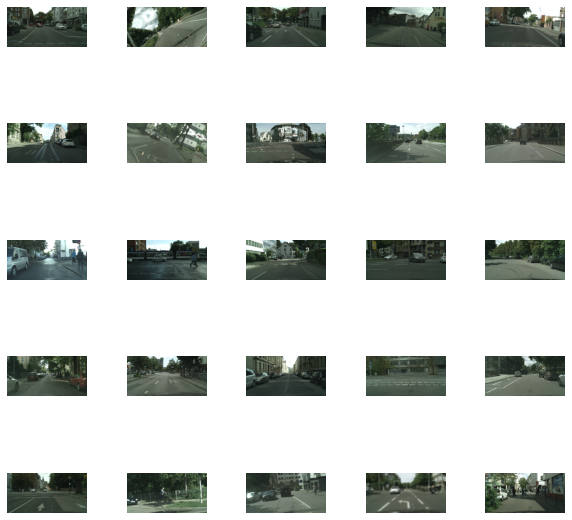

In [18]:
train_generator = datagen.flow(X_train, y_train, batch_size=32, subset='training')
validation_generator = datagen.flow(X_test, y_test, batch_size=32, subset='validation')
train_generator.show_data()

## Entrainement du modèle

In [19]:
%%time
steps_per_epoch = X_train.shape[0] // BATCH_SIZE
validation_steps = X_test.shape[0] // BATCH_SIZE

history = model.fit(
  train_generator,
  steps_per_epoch=len(train_generator),
  epochs=EPOCHS,
  validation_data=validation_generator,
  validation_steps=len(validation_generator),
  callbacks=[callbacks]
)

gc.collect()

Epoch 1/100
56/56 [==============================] - 27s 155ms/step - loss: 0.3324 - accuracy: 0.4032 - iou_coef: 0.2616 - dice_coef: 0.3982 - val_loss: 0.1994 - val_accuracy: 0.6146 - val_iou_coef: 0.3831 - val_dice_coef: 0.5514
INFO:tensorflow:Assets written to: save_model/unet/assets
Epoch 2/100
56/56 [==============================] - 7s 116ms/step - loss: 0.1841 - accuracy: 0.6526 - iou_coef: 0.4113 - dice_coef: 0.5800 - val_loss: 0.1746 - val_accuracy: 0.6553 - val_iou_coef: 0.4338 - val_dice_coef: 0.6021
INFO:tensorflow:Assets written to: save_model/unet/assets
Epoch 3/100
56/56 [==============================] - 7s 119ms/step - loss: 0.1592 - accuracy: 0.7115 - iou_coef: 0.4699 - dice_coef: 0.6353 - val_loss: 0.1487 - val_accuracy: 0.7317 - val_iou_coef: 0.4747 - val_dice_coef: 0.6407
INFO:tensorflow:Assets written to: save_model/unet/assets
Epoch 4/100
56/56 [==============================] - 7s 116ms/step - loss: 0.1469 - accuracy: 0.7375 - iou_coef: 0.4972 - dice_coef: 0.659

## Chargement des poids du meilleur modèle

In [20]:
model = keras.models.load_model('save_model/unet', custom_objects={
    'iou_coef': METRIC_FACTORY['iou_coef'], 
    'dice_coef':METRIC_FACTORY['dice_coef'],
    '_dice_coef_loss':LOSS_FACTORY['dice_loss']
    }
)

In [21]:
# Sauvegarde du modèle pour l'envoyer sur Azure
!cp -r 'save_model' '/content/drive/MyDrive/AI Engineer/P8_Future-Vision-Transport/save_model'

## E-valuation du modèle 

In [22]:
score = model.evaluate(X_test, y_test, verbose=1)
print(f"Loss : {score[0]}")
print(f"Acuracy : {score[1]}")

24/24 [==============================] - 2s 46ms/step - loss: 0.0664 - accuracy: 0.8836 - iou_coef: 0.7206 - dice_coef: 0.8339
Loss : 0.06642939150333405
Acuracy : 0.8836444616317749


## Exemples de prédictions

In [23]:
y_pred = model.predict(X_test)
y_predi = np.argmax(y_pred, axis=3)
y_testi = np.argmax(y_test, axis=3)

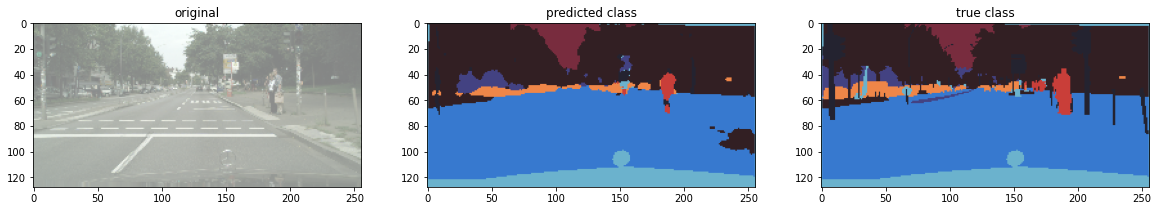

void          : 0.482
flat          : 0.483
construction  : 0.186
object        : 0.139
nature        : 0.449
sky           : 0.473
human         : 0.294
vehicle       : 0.290

Mean IoU: 0.350


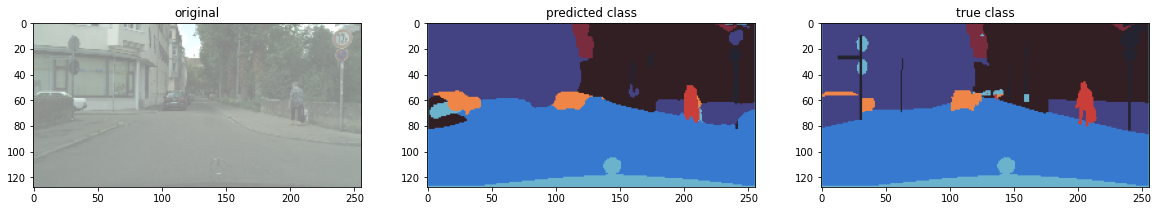

void          : 0.454
flat          : 0.485
construction  : 0.440
object        : 0.171
nature        : 0.471
sky           : 0.476
human         : 0.408
vehicle       : 0.359

Mean IoU: 0.408


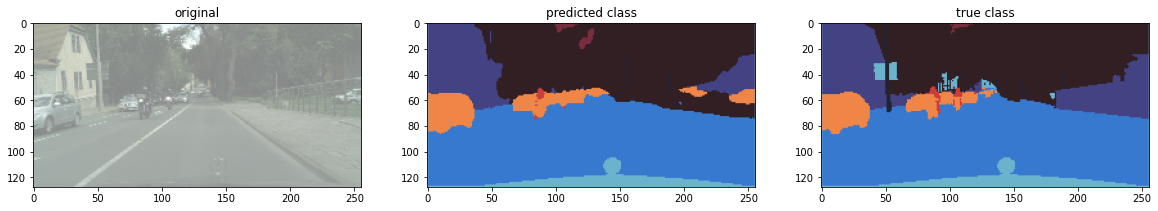

void          : 0.459
flat          : 0.496
construction  : 0.387
object        : 0.123
nature        : 0.458
sky           : 0.251
human         : 0.157
vehicle       : 0.420

Mean IoU: 0.344


In [24]:
import random

random_images = random.sample(range(len(X_test)), 3)

for i in random_images:
    img_is  = (X_test[i] + 1)*(255.0/2)
    seg = y_predi[i]
    segtest = y_testi[i]

    fig = plt.figure(figsize=(20,40))    
    ax = fig.add_subplot(1,3,1)
    ax.imshow(img_is/255.0)
    ax.set_title("original")
    
    ax = fig.add_subplot(1,3,2)
    ax.imshow(set_color_to_mask(seg))
    ax.set_title("predicted class")
    
    ax = fig.add_subplot(1,3,3)
    ax.imshow(set_color_to_mask(segtest))
    ax.set_title("true class")
    plt.show()

    IoU(y_testi[i],y_predi[i],categories)

# Conclusion
L’utilisation de Dice Loss et l’ajout de données permet d’obtenir un modèle plus performant.